# Highly Scalable Data Pipelines with Prefects

## Our Journey in Leveraging Prefect & K8S to enable Resilient, Orchestrated Workflows

### David Zucker
### 2021-09-16

# What is our Team about ?

- Provide to the business advance recommendation
- Ensure quality of data
- Data provider/aggregator for our platform

# What was our evolution ?


## November 2019: First release

**Pro**
- Running on Kubernetes

**Con**
- Single big Pod, Hard to Kubernetes to find space to started
- Took 5h to process the full model
- Use CronJob to schedule the run


## June 2020: First use of Prefect Core

**Pro**
- Running on Kubernetes
- Use Dask for scale out
- Took <1h to process the full model in same time increasing data processed by 10x

**Con**
- Use CronJob to schedule the run
- Hard to get insights about the platform

## February 2021: Move to Prefect Server

**Pro**
- Running on Kubernetes
- Use Dask for scale out
- Took <1h to process the full model
- Use Prefect Server to schedule and get insights about our runs

**Con**
- Still evolving/maturing platform with change from master version


# From Python script to Prefect Core



## The demo use case

- Extract Daily market data at close of exchange
- Need to run on Market Index daily
- Need to load the data as fast as we can at close


# Basic Python implementation

## Solution explanation 

- Extract index composition from Stooq
- Download daily market data for each symbols
- Resample daily candles to weekly and monthly
- Save all result to parquets

In [33]:
import pandas as pd
from typing import List
import os
import time
import pathlib


def index_to_stooq_id(index_name:str)-> str:
    i_2_s = {"DJI": "578",
            "NDX":"580",
            "HSI":"616"}
    return i_2_s[index_name]

def get_index_composition(index_id: str) -> pd.DataFrame:
    return pd.read_html(f"https://stooq.com/t/?i={index_id}", attrs = {"id": "fth1"})[0]

def get_symbols(df_index_composition: pd.DataFrame) -> List[str]:
    return [symbol for symbol in df_index_composition["Symbol"]]

def get_historical_data(symbol: str, time_frame: str="d") -> pd.DataFrame:
    df = pd.read_csv(f"https://stooq.com/q/d/l/?s={symbol}&i={time_frame}", parse_dates=True)
    df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
    return df

In [34]:
def resample_candle(df_daily:pd.DataFrame, resampling: str = "W") -> pd.DataFrame:
    agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Volume': 'mean'}
    df_with_index = df_daily.set_index("Date")
    return df_with_index.resample(resampling).agg(agg_dict).reset_index()

def save_to_parquet(df: pd.DataFrame, path: str):
    pathlib.Path(path).expanduser().parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(path)

In [35]:
%%time

index_name = "DJI"
root_market_data = "~/git/prefect_presentation/market_data"


print(f"=> Extract composition for {index_name}")
index_id = index_to_stooq_id(index_name)
df_composition = get_index_composition(index_id)


for symbol in get_symbols(df_composition)[:6]:
    start = time.time()
    print(f"==> Extract market data for {symbol}", end =" ")
    df_OHLC_daily = get_historical_data(symbol)
    save_to_parquet(df_OHLC_daily, f"{root_market_data}/{index_name}/{symbol}_d.parquet")
    print("Resample W.", end =" ")
    df_OHLC_weekly = resample_candle(df_OHLC_daily, "W")
    save_to_parquet(df_OHLC_weekly, f"{root_market_data}/{index_name}/{symbol}_W.parquet")
    print("M", end =" ")
    df_OHLC_monthly = resample_candle(df_OHLC_daily, "M")
    save_to_parquet(df_OHLC_monthly, f"{root_market_data}/{index_name}/{symbol}_M.parquet")
    end = time.time()
    print(f"took: {end - start:2.2f}s")

=> Extract composition for DJI
==> Extract market data for AAPL.US Resample W. M took: 3.30s
==> Extract market data for AXP.US Resample W. M took: 3.63s
==> Extract market data for BA.US Resample W. M took: 3.73s
==> Extract market data for CAT.US Resample W. M took: 3.66s
==> Extract market data for CSCO.US Resample W. M took: 2.80s
==> Extract market data for CVX.US Resample W. M took: 3.83s
CPU times: user 3.57 s, sys: 231 ms, total: 3.8 s
Wall time: 23.3 s


## Limitation

- Linear execution
- Hard scale out without code complexity (Threading or asyncio)
- No failover/retry capability
- Many edge case to handle to be resilient
- Depend on external solution to schedule

# Upgrading the code with Prefect Core



## Few components you need to know

1. **Task**: Low level execution unit. Simple function decorated with the attribute ```@task```
2. **Flow**: Container of tasks with their dependencies
3. **Parameters**: Special task that allow to change input value of the flow at run time

## Task

``` python
from prefect import task

@task
def plus_one(x):
    return x + 1

```

## Task: Failover support

- max_retries
- retry_delay
- timeout

``` python
from prefect import task
from datetime import timedelta

@task(max_retries=4, retry_delay=timedelta(seconds=10), timeout=timedelta(seconds=2))
def plus_one(x):
    return x + 1
```



## Task: Functional map

- Map allow to iterate a list of element through a task.
- Powerful to distribute work

In [69]:
from prefect import task, Flow, unmapped
from datetime import timedelta
from typing import List

@task
def add(x, y):
    return x + y

@task
def elements() -> List[int]:
     return [x for x in range(1,11)]
    
with Flow("sample") as f:
    ints = elements()
    # Will iterate through all element and add the value 10
    result_add = add.map(x=unmapped(10), y=ints)

flow_state = f.run()


[2021-09-15 15:53:27+0800] INFO - prefect.FlowRunner | Beginning Flow run for 'sample'
[2021-09-15 15:53:28+0800] INFO - prefect.TaskRunner | Task 'elements': Starting task run...
[2021-09-15 15:53:28+0800] INFO - prefect.TaskRunner | Task 'elements': Finished task run for task with final state: 'Success'
[2021-09-15 15:53:28+0800] INFO - prefect.TaskRunner | Task 'add': Starting task run...
[2021-09-15 15:53:28+0800] INFO - prefect.TaskRunner | Task 'add': Finished task run for task with final state: 'Mapped'
[2021-09-15 15:53:28+0800] INFO - prefect.TaskRunner | Task 'add[0]': Starting task run...
[2021-09-15 15:53:28+0800] INFO - prefect.TaskRunner | Task 'add[0]': Finished task run for task with final state: 'Success'
[2021-09-15 15:53:28+0800] INFO - prefect.TaskRunner | Task 'add[1]': Starting task run...
[2021-09-15 15:53:28+0800] INFO - prefect.TaskRunner | Task 'add[1]': Finished task run for task with final state: 'Success'
[2021-09-15 15:53:28+0800] INFO - prefect.TaskRunner

In [70]:
# Let check the result

flow_state.result[result_add].result

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## Task Library

- Set of share task supported by prefect
- Wide variaty that allow simple integration
 
 ### Some example
     - Shellscript
     - KubernetesJob
     - Lambda function
     - Multiple database

## Task Library

![media/prefect_task_1.png](media/prefect_tasks_1.png)

## Task Library

![media/prefect_task_2.png](media/prefect_tasks_2.png)

## Task Library

![media/prefect_task_3.png](media/prefect_tasks_3.png)

## Flow

- Container of task
- Contain the DAG that will run
- Abstract the What to run from the How to run

In [38]:
from prefect import task, Flow, Parameter, unmapped
import pandas as pd
from typing import List
from datetime import timedelta
import os
import time
import pathlib

@task
def index_to_stooq_id(index_name:str)-> str:
    i_2_s = {"DJI": "578",
            "NDX":"580",
            "HSI":"616"}
    return i_2_s[index_name]

@task(max_retries=4, retry_delay=timedelta(seconds=2), timeout=timedelta(seconds=4))
def get_index_composition(index_id: str) -> pd.DataFrame:
    return pd.read_html(f"https://stooq.com/t/?i={index_id}", attrs = {"id": "fth1"})[0]

@task
def get_symbols(df_index_composition: pd.DataFrame) -> List[str]:
    return [symbol for symbol in df_index_composition["Symbol"][:6]]

@task(max_retries=4, retry_delay=timedelta(seconds=2), timeout=timedelta(seconds=6))
def get_historical_data(symbol: str, time_frame: str="d") -> pd.DataFrame:
    df = pd.read_csv(f"https://stooq.com/q/d/l/?s={symbol}&i={time_frame}", parse_dates=True)
    df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
    return df


In [39]:

@task
def resample_candle(df_daily:pd.DataFrame, time_frame: str = "W") -> pd.DataFrame:
    agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Volume': 'mean'}
    df_with_index = df_daily.set_index("Date")
    return df_with_index.resample(time_frame).agg(agg_dict).reset_index()

@task
def get_save_path(root:str, index_name: str, symbol:str, timeframe:str)-> str:
    return f"{root}/{index_name}/{symbol}_{timeframe}.parquet"

@task
def save_to_parquet(df: pd.DataFrame, path: str):
    pathlib.Path(path).expanduser().parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(path)


In [40]:
with Flow("extract_market_data") as f:
    # Define the flow input parameters
    index_name = Parameter("index", default="DJI")
    root_market_data = Parameter("root_folder", "~/git/prefect_presentation/market_data")
    
    # Retrieve the symbols for the index
    index_id = index_to_stooq_id(index_name)
    df_composition = get_index_composition(index_id)
    symbols = get_symbols(df_composition)
    
    # Download the market data for the index
    df_OHLC_daily = get_historical_data.map(symbols)
    daily_path = get_save_path.map(unmapped(root_market_data),unmapped(index_name), symbols, unmapped("d") )
    save_to_parquet.map(df_OHLC_daily, daily_path)
    
    # Resample the market data to Weekly
    df_weekly = resample_candle.map(df_OHLC_daily, unmapped("W"))
    weekly_path = get_save_path.map(unmapped(root_market_data),unmapped(index_name), symbols, unmapped("W") )
    save_to_parquet.map(df_weekly, weekly_path)
    
    # Resample the market data to Monthly
    df_monthly = resample_candle.map(df_OHLC_daily, unmapped("M"))
    monthly_path = get_save_path.map(unmapped(root_market_data),unmapped(index_name), symbols, unmapped("M") )
    save_to_parquet.map(df_monthly, monthly_path)
    
`

## Lets have a look at the workflow

- Prefect view of the DAG
- Show dependencies
- Distinguish mapped and non mapped task

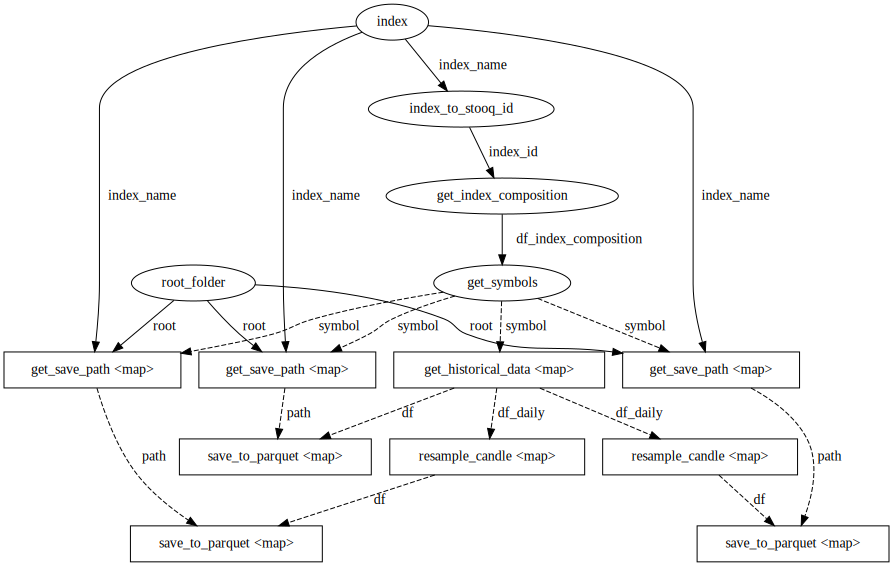

In [41]:
f.visualize()

## Time for a run


In [42]:
%%time
flow_state = f.run(parameters={"index": "DJI"})

[2021-09-15 15:21:21+0800] INFO - prefect.FlowRunner | Beginning Flow run for 'extract_market_data'
[2021-09-15 15:21:21+0800] INFO - prefect.TaskRunner | Task 'index': Starting task run...
[2021-09-15 15:21:21+0800] INFO - prefect.TaskRunner | Task 'index': Finished task run for task with final state: 'Success'
[2021-09-15 15:21:21+0800] INFO - prefect.TaskRunner | Task 'index_to_stooq_id': Starting task run...
[2021-09-15 15:21:21+0800] INFO - prefect.TaskRunner | Task 'index_to_stooq_id': Finished task run for task with final state: 'Success'
[2021-09-15 15:21:21+0800] INFO - prefect.TaskRunner | Task 'get_index_composition': Starting task run...
[2021-09-15 15:21:24+0800] INFO - prefect.TaskRunner | Task 'get_index_composition': Finished task run for task with final state: 'Success'
[2021-09-15 15:21:24+0800] INFO - prefect.TaskRunner | Task 'get_symbols': Starting task run...
[2021-09-15 15:21:24+0800] INFO - prefect.TaskRunner | Task 'get_symbols': Finished task run for task with

[2021-09-15 15:21:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[0]': Finished task run for task with final state: 'Success'
[2021-09-15 15:21:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[1]': Starting task run...
[2021-09-15 15:21:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[1]': Finished task run for task with final state: 'Success'
[2021-09-15 15:21:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[2]': Starting task run...
[2021-09-15 15:21:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[2]': Finished task run for task with final state: 'Success'
[2021-09-15 15:21:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[3]': Starting task run...
[2021-09-15 15:21:49+0800] INFO - prefect.TaskRunner | Task 'get_save_path[3]': Finished task run for task with final state: 'Success'
[2021-09-15 15:21:49+0800] INFO - prefect.TaskRunner | Task 'get_save_path[4]': Starting task run...
[2021-09-15 15:21:49+0800] INFO - prefect.TaskRunner | T

## DAG that prefect ran

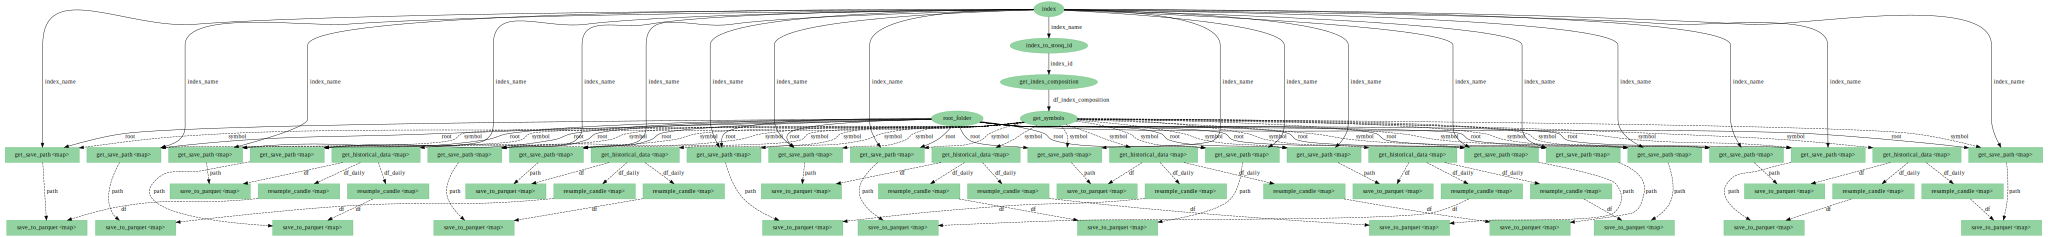

In [43]:
f.visualize(flow_state)


## This look like sequential to me !!!!
```
[2021-09-13 17:25:56+0800] INFO - prefect.TaskRunner | Task 'get_historical_data': Starting task run...
[2021-09-13 17:25:56+0800] INFO - prefect.TaskRunner | Task 'get_historical_data': Finished task run for task with final state: 'Mapped'
[2021-09-13 17:25:56+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[0]': Starting task run...
[2021-09-13 17:26:00+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[0]': Finished task run for task with final state: 'Success'
[2021-09-13 17:26:00+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[1]': Starting task run...
[2021-09-13 17:26:04+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[1]': Finished task run for task with final state: 'Success'
[2021-09-13 17:26:05+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[2]': Starting task run...
[2021-09-13 17:26:10+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[2]': Finished task run for task with final state: 'Success'
[2021-09-13 17:26:10+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[3]': Starting task run...
[2021-09-13 17:26:16+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[3]': Finished task run for task with final state: 'Retrying'
```


# Prefect Modularity

- **Executors**: Define how you want to run your workflow
- **Storage**: Define the where the flow definition are stored.
- **Result**: Define where task result are persisted
- **Serialization**: Define how you want to stream your data
- **State Handle**: 

## Result

- Abstract the result type (Local, S3, Azure Blob Storage...)
- Allow you to define how we want to serialize the result
- Dynamic path generation




In [45]:
from prefect.engine.results import LocalResult
from prefect.engine.serializers import PandasSerializer

MARKET_RESULT = LocalResult(dir="~/market_data/", serializer=PandasSerializer(file_type="parquet"))
TARGET_STOCK = "stock/{today_nodash}/{symbol}.{time_frame}.parquet"

@task(checkpoint=True,
      target="index/{today_nodash}/{index_name}.parquet",
      result=MARKET_RESULT)
def get_index_composition(index_id: str, index_name: str) -> pd.DataFrame:
    return pd.read_html(f"https://stooq.com/t/?i={index_id}", attrs = {"id": "fth1"})[0]

@task(checkpoint=True,
      target=TARGET_STOCK,
      result=MARKET_RESULT)
def get_historical_data(symbol: str, time_frame: str="d") -> pd.DataFrame:
    df = pd.read_csv(f"https://stooq.com/q/d/l/?s={symbol}&i={time_frame}", parse_dates=True)
    df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
    return df

In [46]:
@task(checkpoint=True,
      target=TARGET_STOCK,
      result=MARKET_RESULT)
def resample_candle(df_daily:pd.DataFrame, symbol:str, time_frame: str = "W") -> pd.DataFrame:
    agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Volume': 'mean'}
    df_with_index = df_daily.set_index("Date")
    return df_with_index.resample(time_frame).agg(agg_dict).reset_index()


In [47]:
with Flow("extract_market_data_with_result") as f_with_result:
    # Define the flow input parameters
    index_name = Parameter("index", default="DJI")
    root_market_data = Parameter("root_folder", "~/git/prefect_presentation/market_data")
    
    # Retrieve the symbols for the index
    index_id = index_to_stooq_id(index_name)
    df_composition = get_index_composition(index_id, index_name)
    symbols = get_symbols(df_composition)

    df_OHLC_daily = get_historical_data.map(symbols, unmapped("d"))
    df_weekly = resample_candle.map(df_OHLC_daily, symbols, unmapped("W"))
    df_monthly = resample_candle.map(df_OHLC_daily, symbols, unmapped("M"))
    

/usr/lib/python3.9/contextlib.py:126: UserWarning: Tasks were created but not added to the flow: {<Parameter: root_folder>}. This can occur when `Task` classes, including `Parameters`, are instantiated inside a `with flow:` block but not added to the flow either explicitly or as the input to another task. For more information, see https://docs.prefect.io/core/advanced_tutorials/task-guide.html#adding-tasks-to-flows.
  next(self.gen)


In [50]:
import prefect
prefect.context.config.flows.checkpointing = True
f_with_result.run()

[2021-09-15 15:27:10+0800] INFO - prefect.FlowRunner | Beginning Flow run for 'extract_market_data_with_result'
[2021-09-15 15:27:10+0800] INFO - prefect.TaskRunner | Task 'index': Starting task run...
[2021-09-15 15:27:10+0800] INFO - prefect.TaskRunner | Task 'index': Finished task run for task with final state: 'Success'
[2021-09-15 15:27:10+0800] INFO - prefect.TaskRunner | Task 'index_to_stooq_id': Starting task run...
[2021-09-15 15:27:10+0800] INFO - prefect.TaskRunner | Task 'index_to_stooq_id': Finished task run for task with final state: 'Success'
[2021-09-15 15:27:10+0800] INFO - prefect.TaskRunner | Task 'get_index_composition': Starting task run...
[2021-09-15 15:27:10+0800] INFO - prefect.TaskRunner | Task 'get_index_composition': Finished task run for task with final state: 'Cached'
[2021-09-15 15:27:11+0800] INFO - prefect.TaskRunner | Task 'get_symbols': Starting task run...
[2021-09-15 15:27:11+0800] INFO - prefect.TaskRunner | Task 'get_symbols': Finished task run fo

<Success: "All reference tasks succeeded.">

### Executors

Responsible for actually executing the tasks

- **LocalExecutor**: Single threaded executor in memory
- **LocalDaskExecutor**: Use local dask executor to run in multi-threaded
- **DaskExecutor**: Use Dask distributed to sent task to remote worker

#### Dask: Dask is an open source library for parallel computing written in Python.[


### Running with LocalDaskExecutor

- Initialize a LocalDaskExecutor
- Set the executor in the run function


In [51]:
%%time
from prefect.executors import LocalDaskExecutor 
from flows.extract_market_data import flow_market
executor = LocalDaskExecutor(scheduler="threads", nb_threads="8")
flow_market.run(executor=executor)

[2021-09-15 15:28:35+0800] INFO - prefect.FlowRunner | Beginning Flow run for 'extract_market_data'
[2021-09-15 15:28:36+0800] INFO - prefect.TaskRunner | Task 'root_folder': Starting task run...
[2021-09-15 15:28:36+0800] INFO - prefect.TaskRunner | Task 'index': Starting task run...
[2021-09-15 15:28:36+0800] INFO - prefect.TaskRunner | Task 'root_folder': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:36+0800] INFO - prefect.TaskRunner | Task 'index': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:36+0800] INFO - prefect.TaskRunner | Task 'index_to_stooq_id': Starting task run...
[2021-09-15 15:28:36+0800] INFO - prefect.TaskRunner | Task 'index_to_stooq_id': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:36+0800] INFO - prefect.TaskRunner | Task 'get_index_composition': Starting task run...
[2021-09-15 15:28:39+0800] INFO - prefect.TaskRunner | Task 'get_index_composition': Finished task run for task with

[2021-09-15 15:28:43+0800] INFO - prefect.TaskRunner | Task 'get_save_path[28]': Starting task run...
[2021-09-15 15:28:43+0800] INFO - prefect.TaskRunner | Task 'get_save_path[27]': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:43+0800] INFO - prefect.TaskRunner | Task 'get_save_path[29]': Starting task run...
[2021-09-15 15:28:43+0800] INFO - prefect.TaskRunner | Task 'get_save_path[3]': Starting task run...
[2021-09-15 15:28:44+0800] INFO - prefect.TaskRunner | Task 'get_save_path[28]': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:44+0800] INFO - prefect.TaskRunner | Task 'get_save_path[29]': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:44+0800] INFO - prefect.TaskRunner | Task 'get_save_path[4]': Starting task run...
[2021-09-15 15:28:44+0800] INFO - prefect.TaskRunner | Task 'get_save_path[3]': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:44+0800] INFO - prefect.TaskRunne

[2021-09-15 15:28:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[5]': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[6]': Starting task run...
[2021-09-15 15:28:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[7]': Starting task run...
[2021-09-15 15:28:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[7]': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[9]': Starting task run...
[2021-09-15 15:28:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[8]': Starting task run...
[2021-09-15 15:28:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[6]': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:48+0800] INFO - prefect.TaskRunner | Task 'get_save_path[9]': Finished task run for task with final state: 'Success'
[2021-09-15 15:28:48+0800] INFO - prefect.TaskRunner | T

[2021-09-15 15:29:19+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[8]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:19+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[9]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:19+0800] INFO - prefect.TaskRunner | Task 'get_save_path[10]': Starting task run...
[2021-09-15 15:29:20+0800] INFO - prefect.TaskRunner | Task 'get_save_path[0]': Starting task run...
[2021-09-15 15:29:20+0800] INFO - prefect.TaskRunner | Task 'get_save_path[11]': Starting task run...
[2021-09-15 15:29:20+0800] INFO - prefect.TaskRunner | Task 'get_save_path[1]': Starting task run...
[2021-09-15 15:29:20+0800] INFO - prefect.TaskRunner | Task 'get_save_path[10]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:20+0800] INFO - prefect.TaskRunner | Task 'get_save_path[0]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:20+0800] INFO - prefect

[2021-09-15 15:29:23+0800] INFO - prefect.TaskRunner | Task 'resample_candle[0]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:24+0800] INFO - prefect.TaskRunner | Task 'resample_candle[12]': Starting task run...
[2021-09-15 15:29:24+0800] INFO - prefect.TaskRunner | Task 'resample_candle[14]': Starting task run...
[2021-09-15 15:29:24+0800] INFO - prefect.TaskRunner | Task 'resample_candle[13]': Starting task run...
[2021-09-15 15:29:24+0800] INFO - prefect.TaskRunner | Task 'resample_candle[15]': Starting task run...
[2021-09-15 15:29:24+0800] INFO - prefect.TaskRunner | Task 'resample_candle[12]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:24+0800] INFO - prefect.TaskRunner | Task 'resample_candle[14]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:24+0800] INFO - prefect.TaskRunner | Task 'resample_candle[13]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:24+0800] INFO -

[2021-09-15 15:29:30+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[17]': Starting task run...
[2021-09-15 15:29:30+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[14]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:30+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[16]': Starting task run...
[2021-09-15 15:29:30+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[18]': Starting task run...
[2021-09-15 15:29:30+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[19]': Starting task run...
[2021-09-15 15:29:30+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[16]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:30+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[17]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:30+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[18]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:30+0800] INFO 

[2021-09-15 15:29:36+0800] INFO - prefect.TaskRunner | Task 'resample_candle[2]': Starting task run...
[2021-09-15 15:29:36+0800] INFO - prefect.TaskRunner | Task 'resample_candle[19]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:36+0800] INFO - prefect.TaskRunner | Task 'resample_candle[20]': Starting task run...
[2021-09-15 15:29:37+0800] INFO - prefect.TaskRunner | Task 'resample_candle[21]': Starting task run...
[2021-09-15 15:29:37+0800] INFO - prefect.TaskRunner | Task 'resample_candle[22]': Starting task run...
[2021-09-15 15:29:37+0800] INFO - prefect.TaskRunner | Task 'resample_candle[2]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:37+0800] INFO - prefect.TaskRunner | Task 'resample_candle[23]': Starting task run...
[2021-09-15 15:29:37+0800] INFO - prefect.TaskRunner | Task 'resample_candle[20]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:37+0800] INFO - prefect.TaskRunner | Task 'resampl

[2021-09-15 15:29:43+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[21]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:43+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[22]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:43+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[25]': Starting task run...
[2021-09-15 15:29:43+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[24]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:44+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[23]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:44+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[26]': Starting task run...
[2021-09-15 15:29:44+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[28]': Starting task run...
[2021-09-15 15:29:44+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[27]': Starting task run...
[2021-09-15 15:29:44+0800] INFO 

[2021-09-15 15:29:48+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[26]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:49+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[29]': Starting task run...
[2021-09-15 15:29:49+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[28]': Starting task run...
[2021-09-15 15:29:49+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[27]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:49+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[3]': Starting task run...
[2021-09-15 15:29:49+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[28]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:49+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[29]': Finished task run for task with final state: 'Success'
[2021-09-15 15:29:49+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[4]': Starting task run...
[2021-09-15 15:29:49+0800] INFO - 

<Success: "All reference tasks succeeded.">

### Running with DaskExecutor

- Advance executor to dask
- Require an external dask cluster running
- Allow to scale out

In [52]:
from prefect.executors import DaskExecutor 
from flows.dask_cluster import DaskCluster
from flows.extract_market_data import flow_market
from prefect.utilities.logging import get_logger

logger = get_logger()

with DaskCluster(logger) as cluster:
    executor = DaskExecutor(address=cluster.scheduler_address)
    flow_market.run(executor=executor)

[2021-09-15 15:30:16+0800] INFO - prefect | ==> Starting local Dask with 4 workers.


distributed.diskutils - INFO - Found stale lock file and directory '/home/dzucker/git/prefect_presentation/dask-worker-space/worker-_sng0gip', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/dzucker/git/prefect_presentation/dask-worker-space/worker-uowt125_', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/dzucker/git/prefect_presentation/dask-worker-space/worker-242bczdm', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/dzucker/git/prefect_presentation/dask-worker-space/worker-8czof2yy', purging


[2021-09-15 15:30:20+0800] INFO - prefect | ==> local Dask started on  tcp://127.0.0.1:37983.
[2021-09-15 15:30:20+0800] INFO - prefect | ==> local Dask dashboard available on  http://127.0.0.1:8787/status
[2021-09-15 15:30:20+0800] INFO - prefect.FlowRunner | Beginning Flow run for 'extract_market_data'
[2021-09-15 15:30:20+0800] INFO - prefect.DaskExecutor | Connecting to an existing Dask cluster at tcp://127.0.0.1:37983


/home/dzucker/git/prefect_presentation/venv/lib/python3.9/site-packages/distributed/scheduler.py:5483: UserWarning: Scheduler already contains a plugin with name worker-status; overwriting.
  warnings.warn(


[2021-09-15 15:30:21+0800] INFO - prefect.TaskRunner | Task 'index': Starting task run...
[2021-09-15 15:30:21+0800] INFO - prefect.TaskRunner | Task 'index': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:21+0800] INFO - prefect.TaskRunner | Task 'root_folder': Starting task run...
[2021-09-15 15:30:22+0800] INFO - prefect.TaskRunner | Task 'root_folder': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:22+0800] INFO - prefect.TaskRunner | Task 'index_to_stooq_id': Starting task run...
[2021-09-15 15:30:22+0800] INFO - prefect.TaskRunner | Task 'index_to_stooq_id': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:22+0800] INFO - prefect.TaskRunner | Task 'get_index_composition': Starting task run...
[2021-09-15 15:30:25+0800] INFO - prefect.TaskRunner | Task 'get_index_composition': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:25+0800] INFO - prefect.TaskRunner | Task 'get_symbols': S

[2021-09-15 15:30:28+0800] INFO - prefect.TaskRunner | Task 'get_save_path[15]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:28+0800] INFO - prefect.TaskRunner | Task 'get_save_path[7]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:29+0800] INFO - prefect.TaskRunner | Task 'get_save_path': Starting task run...
[2021-09-15 15:30:29+0800] INFO - prefect.TaskRunner | Task 'get_save_path': Finished task run for task with final state: 'Mapped'
[2021-09-15 15:30:29+0800] INFO - prefect.TaskRunner | Task 'get_save_path[0]': Starting task run...
[2021-09-15 15:30:29+0800] INFO - prefect.TaskRunner | Task 'get_save_path[0]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:29+0800] INFO - prefect.TaskRunner | Task 'get_save_path[2]': Starting task run...
[2021-09-15 15:30:29+0800] INFO - prefect.TaskRunner | Task 'get_save_path[1]': Starting task run...
[2021-09-15 15:30:29+0800] INFO - prefect.TaskRunner | Task 'g

[2021-09-15 15:30:34+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[0]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:35+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[4]': Starting task run...
[2021-09-15 15:30:35+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[3]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:36+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[2]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:36+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[7]': Starting task run...
[2021-09-15 15:30:36+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[6]': Starting task run...
[2021-09-15 15:30:36+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[1]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:36+0800] INFO - prefect.TaskRunner | Task 'get_historical_data[5]': Starting task run...
[2021-09

[2021-09-15 15:30:57+0800] INFO - prefect.TaskRunner | Task 'get_save_path[9]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:57+0800] INFO - prefect.TaskRunner | Task 'get_save_path[8]': Starting task run...
[2021-09-15 15:30:57+0800] INFO - prefect.TaskRunner | Task 'get_save_path[8]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:57+0800] INFO - prefect.TaskRunner | Task 'get_save_path[7]': Starting task run...
[2021-09-15 15:30:57+0800] INFO - prefect.TaskRunner | Task 'get_save_path[7]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:57+0800] INFO - prefect.TaskRunner | Task 'get_save_path[6]': Starting task run...
[2021-09-15 15:30:57+0800] INFO - prefect.TaskRunner | Task 'get_save_path[6]': Finished task run for task with final state: 'Success'
[2021-09-15 15:30:57+0800] INFO - prefect.TaskRunner | Task 'get_save_path[13]': Starting task run...
[2021-09-15 15:30:57+0800] INFO - prefect.TaskRunner | 

[2021-09-15 15:31:00+0800] INFO - prefect.TaskRunner | Task 'resample_candle[9]': Starting task run...
[2021-09-15 15:31:00+0800] INFO - prefect.TaskRunner | Task 'resample_candle[10]': Starting task run...
[2021-09-15 15:31:00+0800] INFO - prefect.TaskRunner | Task 'resample_candle[12]': Starting task run...
[2021-09-15 15:31:00+0800] INFO - prefect.TaskRunner | Task 'resample_candle[9]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:00+0800] INFO - prefect.TaskRunner | Task 'resample_candle[15]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:00+0800] INFO - prefect.TaskRunner | Task 'resample_candle[12]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:00+0800] INFO - prefect.TaskRunner | Task 'resample_candle[10]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:00+0800] INFO - prefect.TaskRunner | Task 'resample_candle[13]': Starting task run...
[2021-09-15 15:31:00+0800] INFO - 

[2021-09-15 15:31:03+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[15]': Starting task run...
[2021-09-15 15:31:03+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[15]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:03+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[14]': Starting task run...
[2021-09-15 15:31:03+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[17]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:03+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[24]': Starting task run...
[2021-09-15 15:31:03+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[14]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:03+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[24]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:03+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[20]': Starting task run...
[2021-09-15 15:31:03+0800] INFO 

[2021-09-15 15:31:06+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[21]': Starting task run...
[2021-09-15 15:31:06+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[20]': Starting task run...
[2021-09-15 15:31:06+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[21]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:06+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[22]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:06+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[25]': Starting task run...
[2021-09-15 15:31:06+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[23]': Starting task run...
[2021-09-15 15:31:06+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[20]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:06+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[25]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:06+0800] INFO 

[2021-09-15 15:31:10+0800] INFO - prefect.TaskRunner | Task 'resample_candle[28]': Starting task run...
[2021-09-15 15:31:10+0800] INFO - prefect.TaskRunner | Task 'resample_candle[23]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:10+0800] INFO - prefect.TaskRunner | Task 'resample_candle[27]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:10+0800] INFO - prefect.TaskRunner | Task 'resample_candle[25]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:10+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet': Starting task run...
[2021-09-15 15:31:10+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet': Finished task run for task with final state: 'Mapped'
[2021-09-15 15:31:10+0800] INFO - prefect.TaskRunner | Task 'resample_candle[24]': Starting task run...
[2021-09-15 15:31:10+0800] INFO - prefect.TaskRunner | Task 'resample_candle[29]': Starting task run...
[2021-09-15 15:31:10+0800] INFO - prefect

[2021-09-15 15:31:13+0800] INFO - prefect.TaskRunner | Task 'save_to_parquet[24]': Finished task run for task with final state: 'Success'
[2021-09-15 15:31:13+0800] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded
[2021-09-15 15:31:13+0800] INFO - prefect | ==> Stopping local Dask.
[2021-09-15 15:31:14+0800] INFO - prefect | ==> Stopped local Dask.


# Prefect Server / Prefect Cloud

## What is Prefect Server

- Allow orchestration and monitoring of flow
- Complete UI for flows and jobs
- Control API using GraphQL
- Automatic and asynchronous scheduling and alerting
- Hybrid mode to make Prefect a reliable option for enterprise ( code and data remain on-prem )

## Prefect Server vs Prefect Cloud

|  | Prefect Server      | Prefect Cloud |
| ---- | ----------- | ----------- |
| License | Open Source (Prefect Community License) | Commecial |
| Authentication | None (Can use reverse Proxy | SSO integreation |
| Permissioning | None | Advance with Role |
| Secret managemnt | None | Managed |
| KV Storage | None | Managed |
| Flow Concurency | None | Ensure nb flow run |
| Alerting | Basic | Advance capability |
| 

## Architecture

![architecture](./media/prefect_architecture_overview.png)

## Start Prefect Sever localy

- Prefect suport local server using Docker
- Perfect for testing

``` bash
./start_prefect_server.sh 
./start_prefect_agent_dask.sh
```

## Prefect Server overview

[Prefect Server url http://localhost:8080](http://localhost:8080)

## Register job

- Register the Job to Prefect Server/Cloud
- Save the Job metadata to the Storage

In [54]:
!./register_flow.sh

==> Register Job Extract_market_data
Processing 'flows/extract_market_data.py':
  Building `Local` storage...
  Registering 'extract_market_data'... Skipped (metadata unchanged)
================== 0 registered, 1 skipped ==================


## Let run our job and check Dask

[Dask Scheduler](http://localhost:8787/status)

# What is our platform today ?

## Our stack

- **Prefect Server**: Running on our own Kubernetes instance
- **Dask Cluster**: Everytime up using dask cluster
    - Running on Kubernetes
    - Leverage HPA using Dask custom metrics *dask_scheduler_desired_workers*
- **S3 Storage**: Using our internal instance of S3 for all our machine learning processing

# Question ?